In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from datetime import datetime

In [2]:
# Data-Set has two different wine types Red-White
#importing the Dataset
df_red_wine = pd.read_csv('winequality-red.csv',sep=';')
df_white_wine = pd.read_csv('winequality-white.csv',sep=';')

#adding a new column Type - 1(Red Wine), 2(White Wine), to datasets
df_red_wine['type'] = 1.0
df_white_wine['type'] = 2.0

#Combining datasets to one 
df_wine = pd.concat([df_red_wine, df_white_wine], axis=0)

In [3]:
# A clean dataset with no NULL values and all numeric values
print(df_wine.isnull().sum())
df_wine.info()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-nul

In [4]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0


In [5]:
df_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,2.0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,2.0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,2.0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,2.0
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,2.0


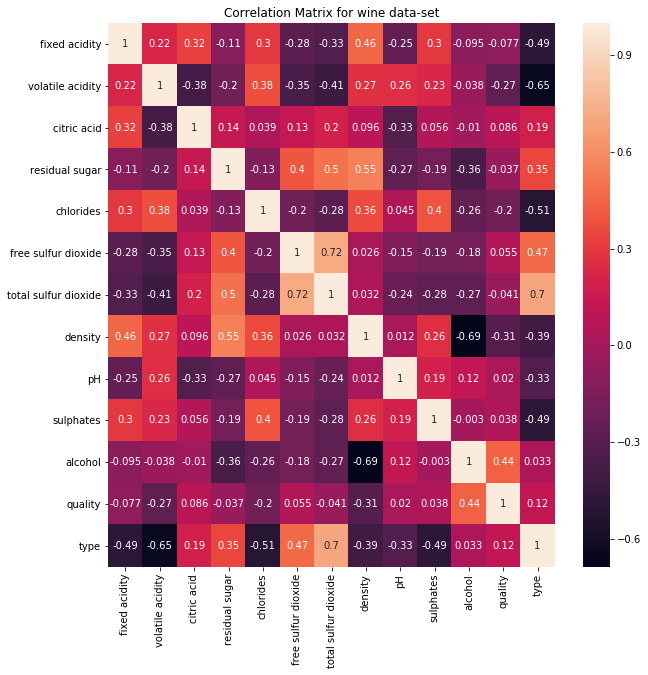

In [6]:
#Analysing Correlation between various features of the wine dataset
wine_corr = df_wine.corr()
figure, ax = plt.subplots(figsize = (10,10))
ax.set_title('Correlation Matrix for wine data-set')
matrix = sns.heatmap(wine_corr,ax=ax, annot= True)

In [7]:
#Feature Selection by dropping features having correlation less than 0.05 with target variable quality
abs_val_wine_corr = wine_corr['quality'].drop('quality').abs()
imp_feature_idx = abs_val_wine_corr[abs_val_wine_corr > 0.05].index.values.tolist()

In [8]:
#Preparing the final dataset
x = df_wine[imp_feature_idx] 
y = df_wine['quality']

In [9]:
#Creating Traning and test set
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0,stratify=y)

In [10]:
#Standardizing the prepared training and test data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
def svr_param_selection(X, y, nfolds):
    Kernels = ['linear', 'poly', 'rbf']
    Cs = [0.001, 0.01, 0.1, 1]
    Gammas = [0.001, 0.01, 0.1]
    param_grid = {'kernel':Kernels, 'C': Cs, 'gamma' : Gammas}
    grid_search = GridSearchCV(SVR(), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('SVR Lowest MSE Score: '+str(grid_search.best_score_))
    print('SVR With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [12]:
def random_forest_regressor_param_selection(X, y, nfolds):
    Estimators = np.arange(1,100,15)
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'n_estimators': Estimators, 'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('RandomForestRegressor Lowest MSE Score: '+str(grid_search.best_score_))
    print('RandomForestRegressor With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [13]:
def decision_tree_regressor_param_selection(X, y, nfolds):
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('DecisionTreeRegressor Lowest MSE Score: '+str(grid_search.best_score_))
    print('DecisionTreeRegressor With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [14]:
def ada_boost_regressor_param_selection(X, y, nfolds):
    Estimators = np.arange(1,100,15)
    Learning_rates = [0.01,0.05,0.1,0.3]
    Losses = ['linear', 'square', 'exponential']
    param_grid = {'n_estimators': Estimators, 'learning_rate': Learning_rates, 'loss': Losses}
    grid_search = GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('AdaBoostRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('AdaBoostRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [15]:
def gaussian_regressor_param_selection(X, y, nfolds):
    kernel_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
    kernel_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
    kernel_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
    Kernels = [kernel_rbf, kernel_rq, kernel_expsine]
    param_grid = {'kernel': Kernels}
    grid_search = GridSearchCV(GaussianProcessRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('GaussianRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('GaussianRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [16]:
def linear_regressor_param_selection(X, y, nfolds):
    param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('LinearRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('LinearRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [17]:
def neural_network_regressor_param_selection(X, y, nfolds):
    Learning_rates = ['constant','adaptive']
    Learning_rates_init = [0.001, 0.01, 0.1, 0.3]
    Hidden_Layer_Sizes = [1, 5, 10, (5,5), (10,5)]
    Activations = ['logistic', 'tanh', 'relu']
    Alphas = [0.0001,0.002]
    param_grid = {'learning_rate': Learning_rates, 'learning_rate_init': Learning_rates_init, 'hidden_layer_sizes': Hidden_Layer_Sizes, 'activation': Activations, 'alpha': Alphas}
    grid_search = GridSearchCV(MLPRegressor(max_iter=900), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('NeuralNetworkRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('NeuralNetworkRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [20]:
#Using the 3-Fold HyperParam Search to evaluate the best hyperparams for each model
print("now ="+str(datetime.now()))
svr_best_param           = svr_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
random_forest_best_param = random_forest_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
decision_tree_best_param = decision_tree_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
ada_boost_best_param     = ada_boost_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
linear_best_param         = linear_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
neural_network_best_param = neural_network_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
#gaussian_best_param       = gaussian_regressor_param_selection(x_train_scaled, y_train, 3)
#print("now ="+str(datetime.now()))

now =2019-11-03 19:11:45.765334
SVR Lowest MSE Score: 0.33954521683822225
SVR With Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
now =2019-11-03 19:12:35.742712
RandomForestRegressor Lowest MSE Score: 0.33656483956306776
RandomForestRegressor With Parameters: {'max_features': 'auto', 'min_samples_leaf': 0.01, 'n_estimators': 91}
now =2019-11-03 19:12:51.005413
DecisionTreeRegressor Lowest MSE Score: 0.27523751683300113
DecisionTreeRegressor With Parameters: {'max_features': 'auto', 'min_samples_leaf': 0.05}
now =2019-11-03 19:12:51.146029
AdaBoostRegressor Lowest MSE Score:0.35307884732665845
AdaBoostRegressor With Parameters:{'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 91}
now =2019-11-03 19:14:18.680379
LinearRegressor Lowest MSE Score:0.27635335642735737
LinearRegressor With Parameters:{'copy_X': True, 'fit_intercept': True, 'normalize': True}
now =2019-11-03 19:14:18.856553
NeuralNetworkRegressor Lowest MSE Score:0.3369275047766063
NeuralNetworkRegressor With Par

In [ ]:
#Checking MSE of each of the best regressors on test data

In [18]:
print("now ="+str(datetime.now()))
svr_best_param           = svr_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))

now =2019-11-13 10:59:02.298083
SVR Lowest MSE Score: 0.33954521683822225
SVR With Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
now =2019-11-13 10:59:29.787709


In [33]:
best_svr = SVR(C=1, gamma=0.1, kernel='rbf')
best_svr.fit(x_train_scaled, y_train)
y_pred = best_svr.predict(x_test_scaled)
print('MSE for SVR: '+str(mean_squared_error(y_test, y_pred)))
print(best_svr.score(x_test_scaled))

MSE for SVR: 0.5098582658496492


In [34]:
best_decision_tree_regressor = DecisionTreeRegressor(max_features='auto', min_samples_leaf=0.05, random_state=0)
best_decision_tree_regressor.fit(x_train_scaled, y_train)
y_pred = best_decision_tree_regressor.predict(x_test_scaled)
print('MSE for Decision Tree Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Decision Tree Regressor: 0.5859696750104505


In [35]:
best_random_forest_regressor = RandomForestRegressor(max_features='auto', min_samples_leaf=0.01, n_estimators=91, random_state=0)
best_random_forest_regressor.fit(x_train_scaled, y_train)
y_pred = best_random_forest_regressor.predict(x_test_scaled)
print('MSE for Random Forest Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Random Forest Regressor: 0.5304160974580991


In [36]:
best_ada_boost_regressor = AdaBoostRegressor(learning_rate=0.01, loss='linear', n_estimators=91, random_state=0)
best_ada_boost_regressor.fit(x_train_scaled, y_train)
y_pred = best_ada_boost_regressor.predict(x_test_scaled)
print('MSE for AdaBoost Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for AdaBoost Regressor: 0.5745866853963647


In [37]:
best_linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
best_linear_regressor.fit(x_train_scaled, y_train)
y_pred = best_linear_regressor.predict(x_test_scaled)
print('MSE for Linear Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Linear Regressor: 0.5618535387986636


In [38]:
best_neural_network_regressor = MLPRegressor(activation='logistic', alpha=0.002, hidden_layer_sizes=(10, 5), learning_rate='constant', learning_rate_init=0.01, random_state=0)
best_neural_network_regressor.fit(x_train_scaled, y_train)
y_pred = best_neural_network_regressor.predict(x_test_scaled)
print('MSE for Neural Network Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Neural Network Regressor: 0.5203408222175507
